In [1]:
from PIL import Image
import numpy as np 
import os 


import numpy as np
import matplotlib.pyplot as pl
import torch
import ot
import ot.plot

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Enable interactive mode
%matplotlib ipympl
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [111]:

image = Image.open('/home/dimakot55/workspace/gaussian-splatting/notebooks/cat_doodle.jpeg')  # Replace 'your_image.bmp' with the path to your image

# Convert the image to a NumPy array
image_array = np.array(image)[...,0] < 0.5

# Get the shape of the image (height and width)
height, width = image_array.shape

# Create an empty list to store the points
points = []

# Iterate through the image array to find points with values greater than 0
for y in range(height):
    for x in range(width):
        if image_array[y, x] > 0:
            # Normalize the coordinates to the [0, 1] range
            normalized_x = x / width
            normalized_y = 1. - y / height
            points.append((normalized_x, normalized_y))


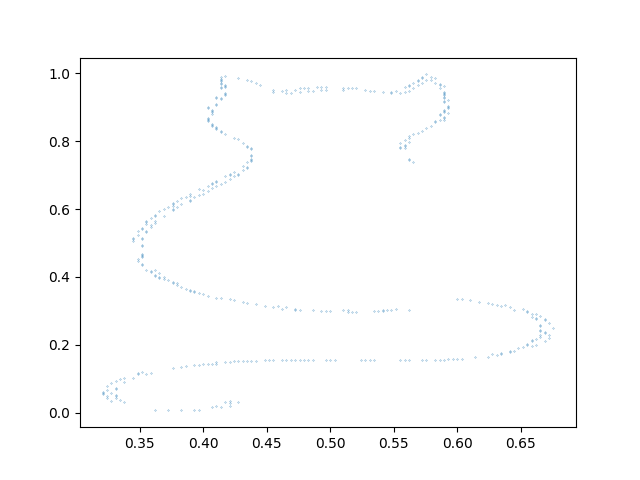

In [112]:
points = np.array(points)
pl.figure()
pl.scatter(points[:,0], points[:,1], s=0.05)
pl.show()

In [113]:
len(points)

428

# Initialize points for optimization

In [114]:
device="cuda"
target_local_shape = torch.tensor(points, device=device)
points_torch = torch.nn.Parameter(torch.randn_like(torch.tensor(points * 1., device=device)))


In [116]:
num_nns = 30
distances = torch.cdist(target_local_shape, target_local_shape)
_, nns_indices = torch.topk(distances, k=num_nns, largest=False, dim=-1)


In [128]:
nns_indices

tensor([[  0,   3,   4,  ...,  72,  75,  71],
        [  1,   2,   8,  ...,  50,  83,  39],
        [  2,   1,   8,  ...,  83,  50,  69],
        ...,
        [425, 426, 424,  ..., 400, 399, 397],
        [426, 427, 425,  ..., 403, 397, 399],
        [427, 426, 425,  ..., 403, 397, 399]], device='cuda:0')

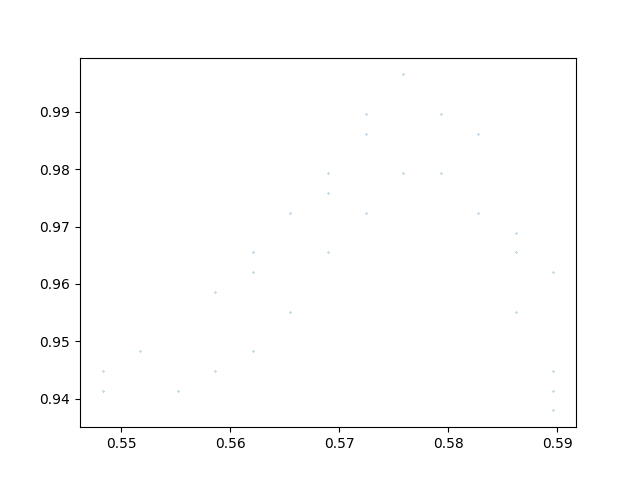

In [117]:
points_arr = np.array(target_local_shape.detach().cpu().numpy())
indices_for_sample = nns_indices[0].detach().cpu().numpy()
pl.figure()
pl.scatter(points_arr[indices_for_sample,0], points_arr[indices_for_sample,1], s=0.05)
pl.show()

In [118]:
points_torch[nns_indices].shape

torch.Size([428, 30, 2])

In [120]:
target_descriptor = get_descriptors(X=target_local_shape, X_nns_indices=nns_indices)

In [121]:
target_descriptor.shape

torch.Size([428, 30, 30])

In [122]:
points_torch

Parameter containing:
tensor([[-5.1077e-01,  5.5576e-01],
        [-7.3048e-01, -7.7609e-01],
        [-1.0779e+00,  7.4814e-01],
        [-2.3370e-01, -2.4693e-01],
        [-5.1574e-01,  1.3208e-01],
        [-1.7390e+00,  2.0761e+00],
        [-5.5663e-01, -1.3639e+00],
        [-3.4656e-01,  4.4312e-01],
        [ 7.3977e-01,  7.9463e-01],
        [-1.8866e+00, -9.0850e-01],
        [ 2.4703e-01, -1.0569e+00],
        [ 1.1939e+00,  9.6972e-02],
        [-1.1592e+00, -1.0530e+00],
        [ 1.9702e+00, -4.8183e-01],
        [ 5.7035e-02, -8.5727e-01],
        [-6.9643e-01, -1.1285e-01],
        [ 3.3915e-01, -6.3852e-01],
        [ 9.9540e-02, -2.5085e-01],
        [ 3.8843e-01, -5.6183e-01],
        [ 3.0397e-01, -2.0386e-01],
        [-6.8420e-01,  2.1311e+00],
        [ 9.0942e-01, -8.7591e-01],
        [-1.4069e+00,  7.4681e-01],
        [-1.1321e-01,  1.4732e+00],
        [ 1.0482e+00,  1.2053e+00],
        [-1.6508e+00, -1.1801e-01],
        [-7.9658e-01, -9.2135e-01],
      

loss_coords_local:3.3688429


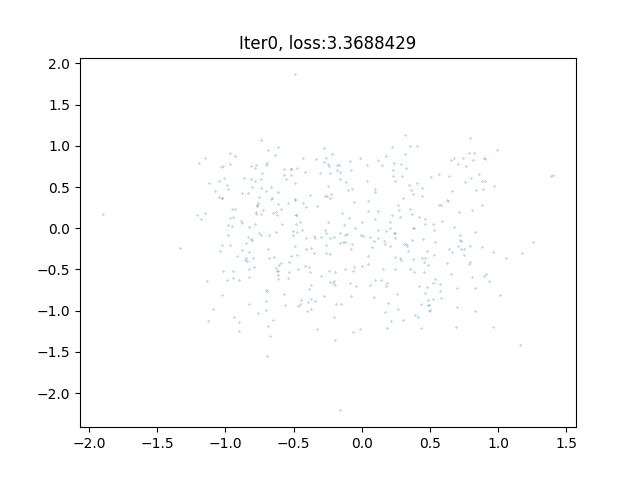

loss_coords_local:0.0001047


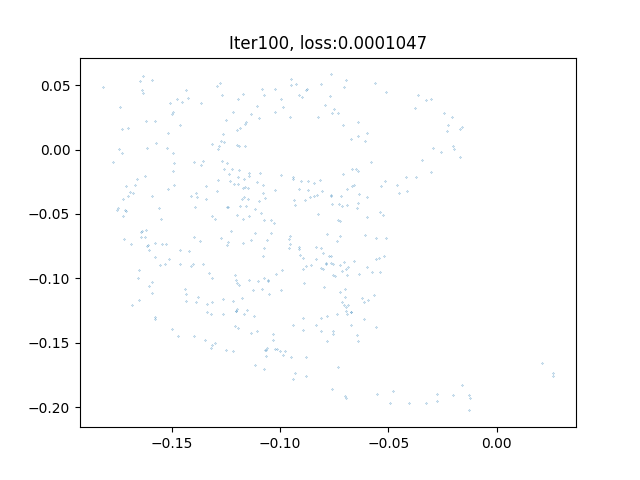

loss_coords_local:0.0000120


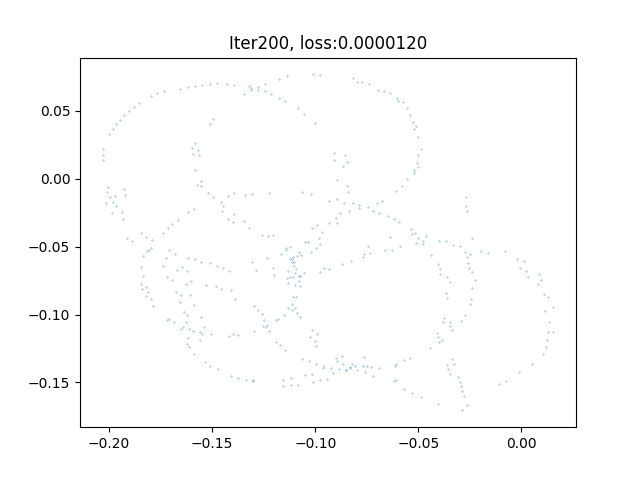

loss_coords_local:0.0000072


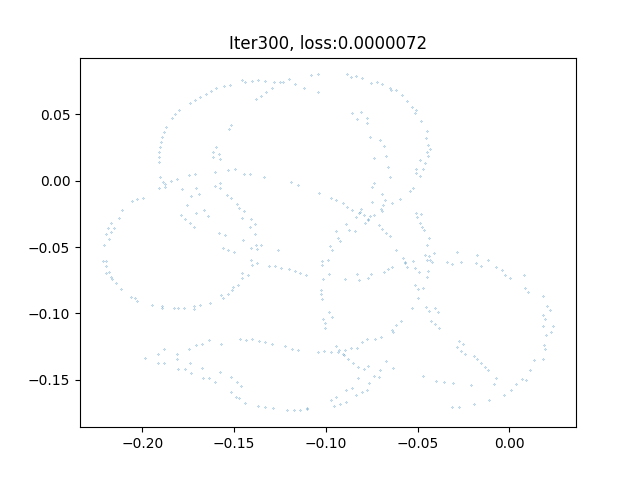

loss_coords_local:0.0000049


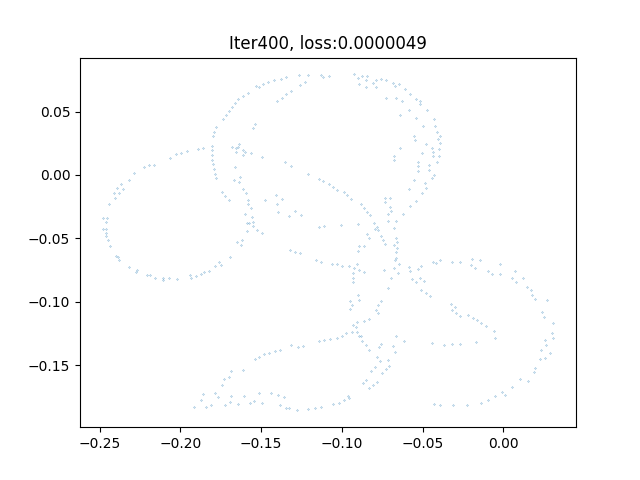

loss_coords_local:0.0000036


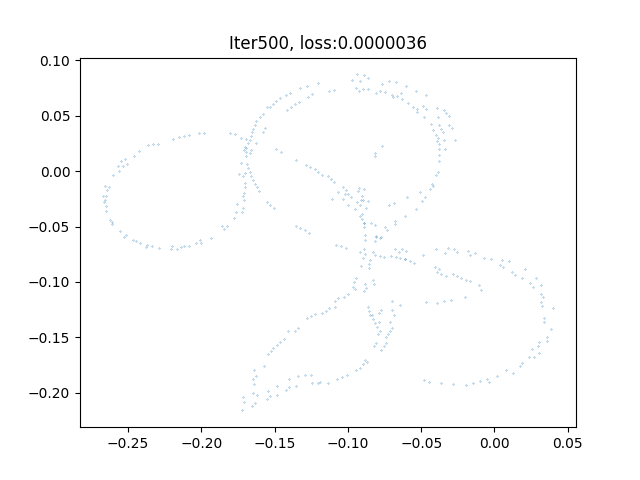

loss_coords_local:0.0000027


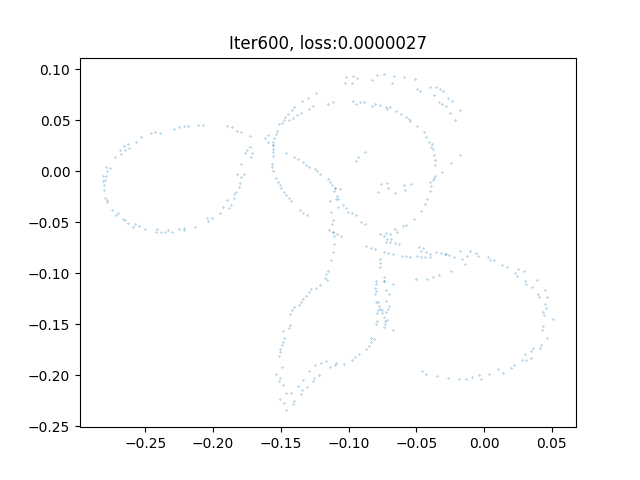

loss_coords_local:0.0000020


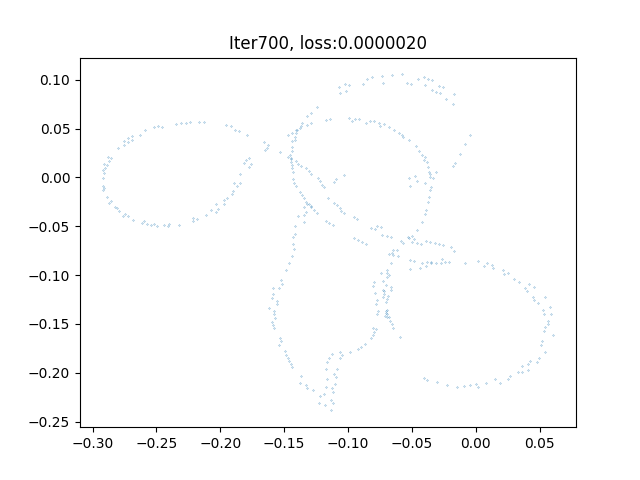

loss_coords_local:0.0000015


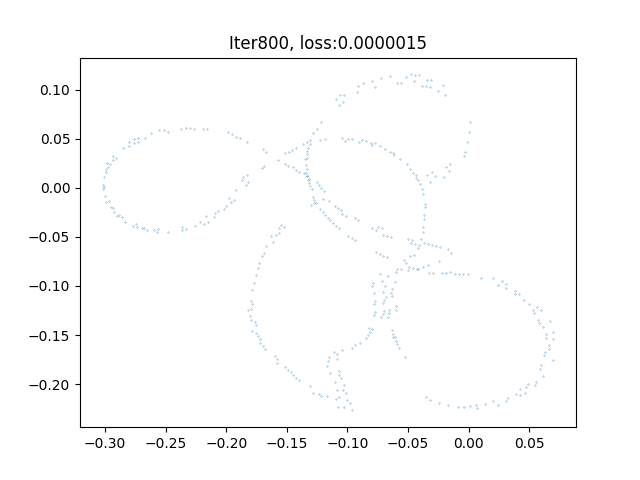

loss_coords_local:0.0000013


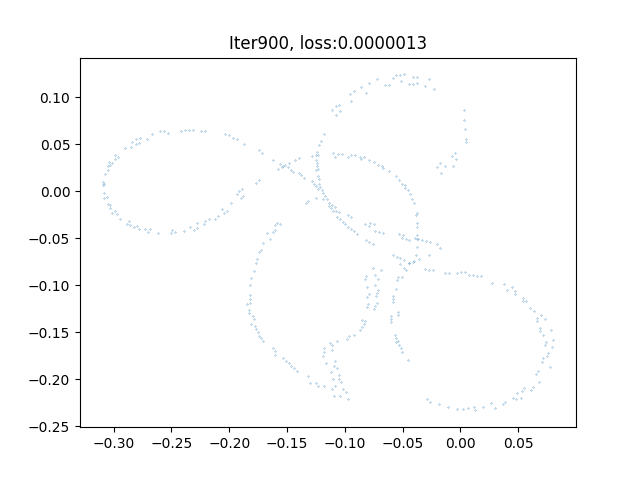

loss_coords_local:0.0000011


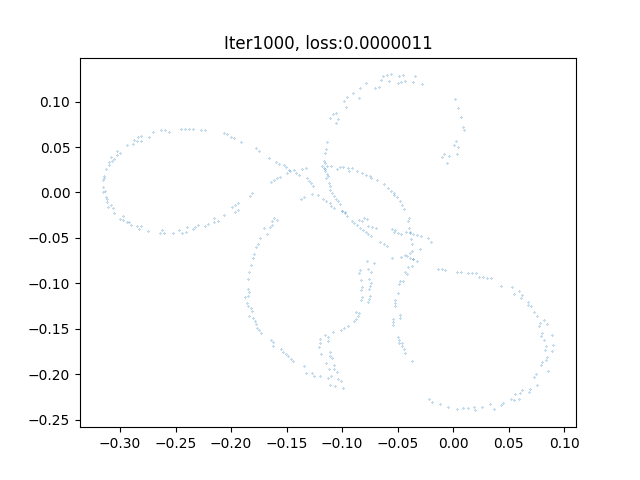

In [123]:


optimizer = torch.optim.Adam([points_torch], lr=1)

for iter in range(1001):
    descriptor = get_descriptors(X=points_torch, X_nns_indices=nns_indices)
    loss_coords_local = torch.mean(torch.square(descriptor - target_descriptor))#*D_pairwise_target_mask)
    
    loss = loss_coords_local*1e0 #+ loss_D_to_shape * 3e-1
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if iter % 100 == 0:
        print(f"loss_coords_local:{loss_coords_local:.7f}")#, loss_D_to_shape:{loss_D_to_shape:.7f}")

        points = np.array(points_torch.clone().detach().cpu().numpy())
        pl.figure()
        pl.title(f"Iter{iter}, loss:{loss:.7f}")
        pl.scatter(points[:,0], points[:,1], s=0.05)
        pl.show()
        

# Now optimize additionally using vector field (vectors attached to every point of the original points) 

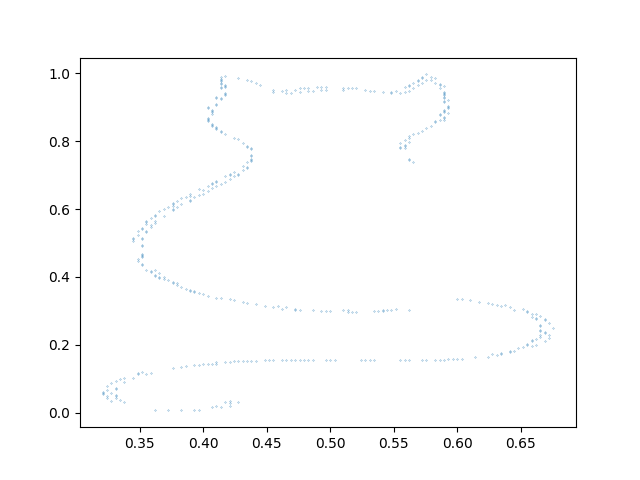

In [129]:

image = Image.open('/home/dimakot55/workspace/gaussian-splatting/notebooks/cat_doodle.jpeg')  # Replace 'your_image.bmp' with the path to your image

# Convert the image to a NumPy array
image_array = np.array(image)[...,0] < 0.5

# Get the shape of the image (height and width)
height, width = image_array.shape

# Create an empty list to store the points
points = []

# Iterate through the image array to find points with values greater than 0
for y in range(height):
    for x in range(width):
        if image_array[y, x] > 0:
            # Normalize the coordinates to the [0, 1] range
            normalized_x = x / width
            normalized_y = 1. - y / height
            points.append((normalized_x, normalized_y))
points = np.array(points)
pl.figure()
pl.scatter(points[:,0], points[:,1], s=0.05)
pl.show()

In [138]:
 
device= "cuda"
vecs = np.random.normal(size=points.shape) / 30.
vecs_indices = np.random.permutation(len(vecs))[:20]

cmap = plt.get_cmap("Set1", max(vecs_indices))
colors = cmap(indices)


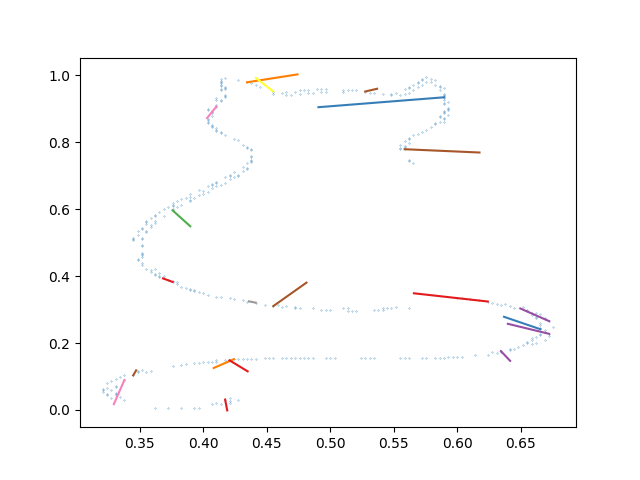

In [139]:
pl.figure()
pl.scatter(points[:,0], points[:,1], s=0.05)

for i in range(len(vecs_indices)): 
    idx = vecs_indices[i]
    pl.plot([points[idx,0], points[idx,0] + vecs[idx,0]],
            [points[idx,1], points[idx,1] + vecs[idx,1]],
           color=colors[i])
pl.show()

## Now init parameters for points and vectors and target points and target to optimize for 

In [174]:
def get_descriptors(X, X_nns_indices):
    """
    Returns a matrix of distances between all points specified in the X_nns_indices matrix.
    :param X: tensor or shape [N,d]
    :param X_nns_indices: tensor of shape [N,k]
    :return 
        distances_nns : tensor of shape [N, k,k] with pairwise distances between all of the 
            k NNs for every sample in X.
    """
    
    X_nns = X[X_nns_indices]
    distances_nns = torch.norm(X_nns.unsqueeze(1) - X_nns.unsqueeze(2), dim=-1)
    return distances_nns

def get_descriptors_vec(X, X_vec, X_nns_indices):
    """
    Returns a matrix of distances between all points specified in the X_nns_indices matrix.
    :param X: tensor or shape [N,d]
    :param X_vec: tensor or shape [N,l] that represents a vector assigned to every point from X. 
        can be of different dimensionality then X.
    :param X_nns_indices: tensor of shape [N,k]
    :return 
        X_offsets_to_vec : tensor of shape [N, k,d] with pairwise offsets from the vector at the 
            query point to all the neighbors offsets.
    """
    
    X_nns = X[X_nns_indices]
    # Compute relative offsets from the curernt vector to all of its neighbors. 
    # also remove the root element
    #print("X_nns.shape:", X_nns.shape)
    #print("X_nns[:,0].unsqueeze(1).shape:", X_nns[:,0].unsqueeze(1).shape)
    X_nns_offsets = X_nns[:,1:] - X_nns[:,0].unsqueeze(1)
    # Now compute the differences from the vector to the offsets
    #X_offsets_to_vec = X_vec.unsqueeze(1) - X_nns_offsets
    X_offsets_to_vec = torch.norm(X_vec.unsqueeze(1) - X_nns_offsets, dim=-1)
    return X_offsets_to_vec
    

target_descriptor_vecs.shape: torch.Size([428, 69])
loss_points_local:3.9631413, loss_vecs:6.0509482


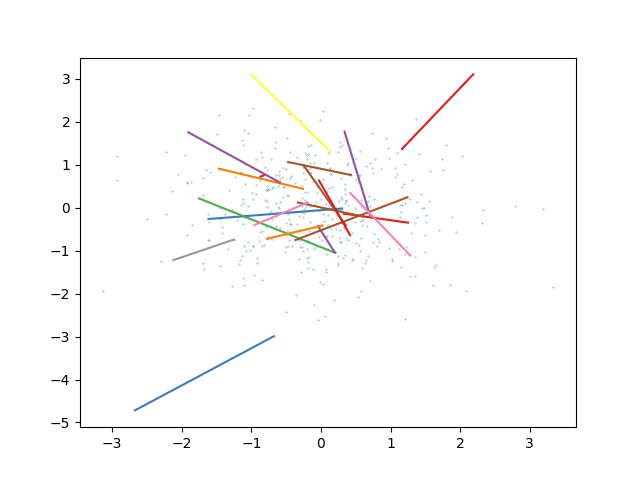

loss_points_local:0.0006639, loss_vecs:0.0005269


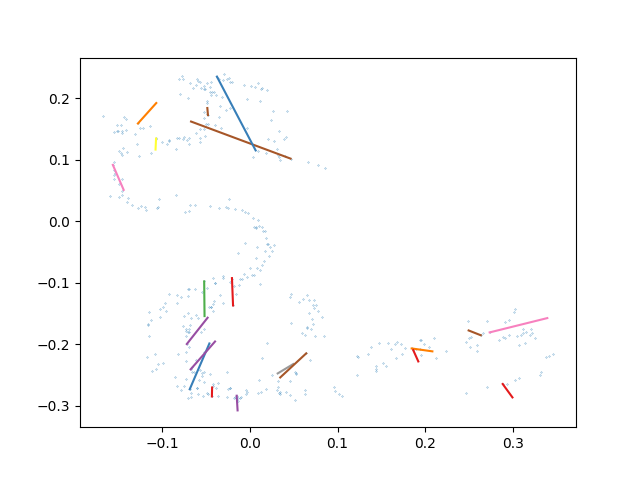

loss_points_local:0.0001777, loss_vecs:0.0001313


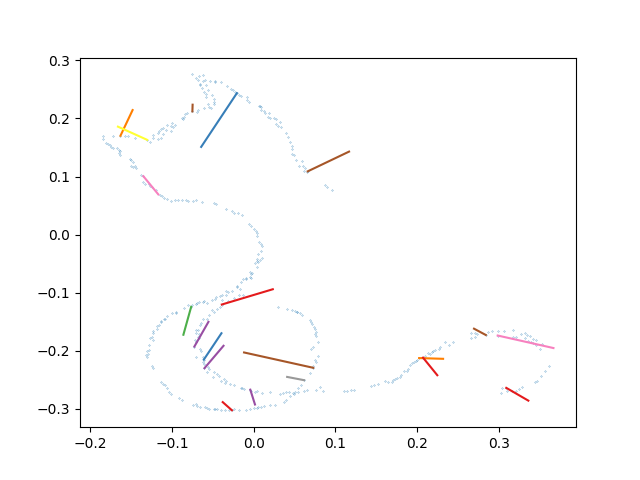

loss_points_local:0.0001558, loss_vecs:0.0001074


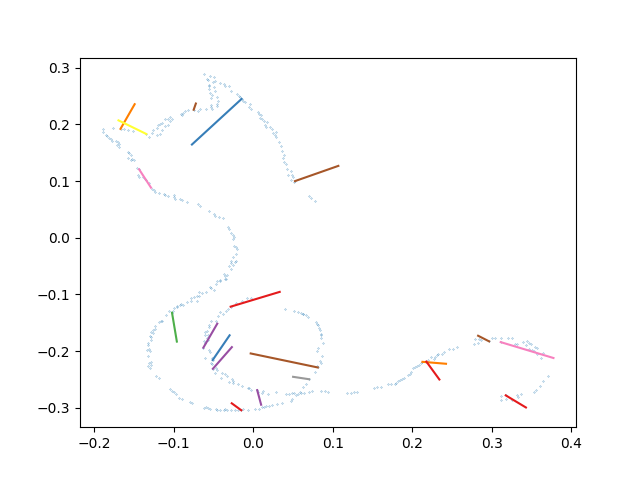

In [180]:
device="cuda"
target_points_torch = torch.tensor(points, device=device)
target_vecs_torch = torch.tensor(vecs, device=device)
points_torch = torch.nn.Parameter(torch.randn_like(torch.tensor(points * 1., device=device)))
vecs_torch = torch.nn.Parameter(torch.randn_like(torch.tensor(vecs * 1., device=device)))

# Compute nearest neighbors and target descriptors for both points and vecs
num_nns = 70
distances = torch.cdist(target_points_torch, target_points_torch)
_, nns_indices = torch.topk(distances, k=num_nns, largest=False, dim=-1)

target_descriptor_points = get_descriptors(X=target_points_torch, X_nns_indices=nns_indices)
target_descriptor_vecs = get_descriptors_vec(X=target_points_torch, X_vec=target_vecs_torch, X_nns_indices=nns_indices)#[:,20])
print("target_descriptor_vecs.shape:", target_descriptor_vecs.shape)



optimizer = torch.optim.Adam([points_torch, vecs_torch], lr=1e-1)

for iter in range(301):
    descriptor_points = get_descriptors(X=points_torch, X_nns_indices=nns_indices)
    descriptor_vecs = get_descriptors_vec(X=points_torch, X_vec=vecs_torch,  X_nns_indices=nns_indices)
    #print("descriptor_vecs.shape:", descriptor_vecs.shape)
    loss_points_local = torch.mean(torch.square(descriptor_points - target_descriptor_points))#*D_pairwise_target_mask)
    loss_vecs = torch.mean(torch.square(descriptor_vecs - target_descriptor_vecs))#*D_pairwise_target_mask)
    
    loss = loss_points_local*1e0 + loss_vecs * 1e0#+ loss_D_to_shape * 3e-1
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if iter % 100 == 0:
        print(f"loss_points_local:{loss_points_local:.7f}, loss_vecs:{loss_vecs:.7f}")#, loss_D_to_shape:{loss_D_to_shape:.7f}")

        points_ = np.array(points_torch.clone().detach().cpu().numpy())
        vecs_ = np.array(vecs_torch.clone().detach().cpu().numpy()) #* 0.01
        
        pl.figure()
        pl.scatter(points_[:,0], points_[:,1], s=0.05)
        
        for i in range(len(vecs_indices)): 
            idx = vecs_indices[i]
            pl.plot([points_[idx,0], points_[idx,0] + vecs_[idx,0]],
                    [points_[idx,1], points_[idx,1] + vecs_[idx,1]],
                   color=colors[i])
        pl.show()


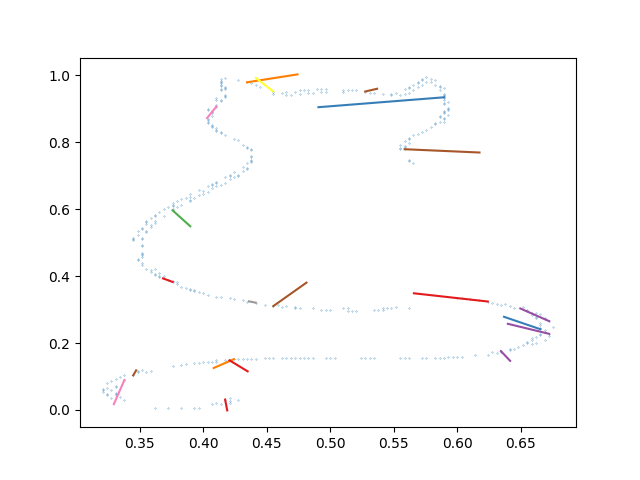

In [153]:
pl.figure()
pl.scatter(points[:,0], points[:,1], s=0.05)

for i in range(len(vecs_indices)): 
    idx = vecs_indices[i]
    pl.plot([points[idx,0], points[idx,0] + vecs[idx,0]],
            [points[idx,1], points[idx,1] + vecs[idx,1]],
           color=colors[i])
pl.show()

# Now repeat this but for real 3d points from an actual lego cluster.

In [181]:
loaded_data = np.load("clusters.npz")

# Access the arrays by their names
gaussians_xyz = loaded_data['gaussians_xyz']
gaussians_target_xyz = loaded_data['gaussians_target_xyz']
gaussians_shape_xyz = loaded_data['gaussians_shape_xyz']

Text(0.5, 0, 'Z Label')

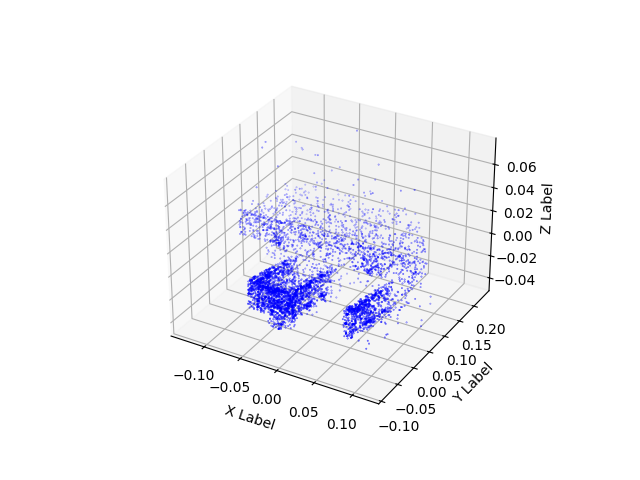

In [182]:

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the scatter points
ax.scatter(gaussians_target_xyz[:,0], 
           gaussians_target_xyz[:,1], 
           gaussians_target_xyz[:,2], c='b', marker='o',s=0.1)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

In [183]:
plt.close()

Text(0.5, 0, 'Z Label')

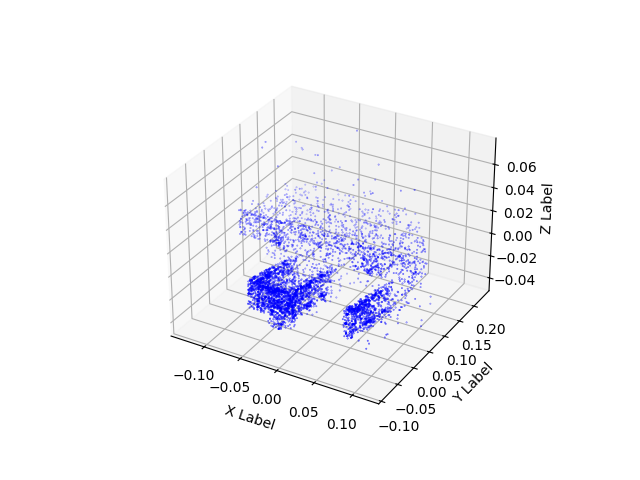

In [374]:

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the scatter points
ax.scatter(gaussians_target_xyz[:,0], 
           gaussians_target_xyz[:,1], 
           gaussians_target_xyz[:,2], c='b', marker='o',s=0.1)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

Text(0.5, 0, 'Z Label')

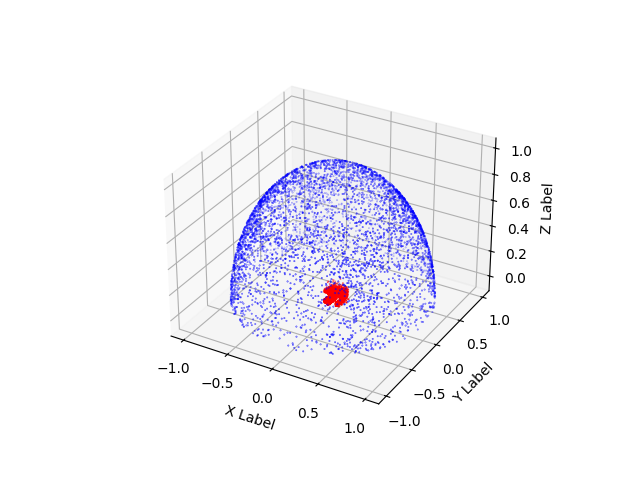

In [184]:


# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the scatter points
ax.scatter(gaussians_shape_xyz[:,0], 
           gaussians_shape_xyz[:,1], 
           gaussians_shape_xyz[:,2], c='b', marker='o',s=0.1)



# Plot the scatter points
ax.scatter(gaussians_target_xyz[:,0], 
           gaussians_target_xyz[:,1], 
           gaussians_target_xyz[:,2], c='r', marker='x',s=0.1)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

In [185]:
plt.close()

## Now actually optimize

In [189]:
loaded_data['gaussians_target_rotation'][...,:-1].shape

(4893, 3)

In [378]:
def get_descriptors(X, X_nns_indices):
    """
    Returns a matrix of distances between all points specified in the X_nns_indices matrix.
    :param X: tensor or shape [N,d]
    :param X_nns_indices: tensor of shape [N,k]
    :return 
        distances_nns : tensor of shape [N, k,k] with pairwise distances between all of the 
            k NNs for every sample in X.
    """
    
    X_nns = X[X_nns_indices]
    # All pairs can be too much
    # distances_nns = torch.norm(X_nns.unsqueeze(1) - X_nns.unsqueeze(2), dim=-1)
    # Just take all distances to the nearest neighbors
    distances_nns = torch.norm(X_nns[:,1:] - X_nns[:,0].unsqueeze(1), dim=-1)
    return distances_nns

def get_descriptors_vec(X, X_vec, X_nns_indices):
    """
    Returns a matrix of distances between all points specified in the X_nns_indices matrix.
    :param X: tensor or shape [N,d]
    :param X_vec: tensor or shape [N,l] that represents a vector assigned to every point from X. 
        can be of different dimensionality then X.
    :param X_nns_indices: tensor of shape [N,k]
    :return 
        X_offsets_to_vec : tensor of shape [N, k,d] with pairwise offsets from the vector at the 
            query point to all the neighbors offsets.
    """
    
    X_nns = X[X_nns_indices]
    # Compute relative offsets from the curernt vector to all of its neighbors. 
    # also remove the root element
    #print("X_nns.shape:", X_nns.shape)
    #print("X_nns[:,0].unsqueeze(1).shape:", X_nns[:,0].unsqueeze(1).shape)
    X_nns_offsets = X_nns[:,1:] - X_nns[:,0].unsqueeze(1)
    # Now compute the differences from the vector to the offsets
    #X_offsets_to_vec = X_vec.unsqueeze(1) - X_nns_offsets
    # print("X_vec.unsqueeze(1):", X_vec.unsqueeze(1).shape)
    # print("X_nns_offsets:", X_nns_offsets.shape)

    # Old version
    # X_offsets_to_vec = torch.norm(X_vec.unsqueeze(1) - X_nns_offsets, dim=-1)
    # return X_offsets_to_vec
    # New version for arbitrary dimension
    
    # Another old version
    # X_offsets_to_vec = None
    # for i in range(l-d+1):
    #     if X_offsets_to_vec is not None:
    #         X_offsets_to_vec = torch.cat((X_offsets_to_vec, torch.norm(X_vec[...,i:i+d].unsqueeze(1) - X_nns_offsets, dim=-1)), dim=1)
    #     else:
    #         X_offsets_to_vec = torch.norm(X_vec[...,i:i+d].unsqueeze(1) - X_nns_offsets, dim=-1)
    subsets = [[0,1,2], [0,1,3], [0,2,3],[1,2,3]]
    X_offsets_to_vec=torch.cat([torch.norm(X_vec[...,subset].unsqueeze(1) - X_nns_offsets, dim=-1)  for subset in subsets], dim=1)
    #print("X_offsets_to_vec.shape:", X_offsets_to_vec.shape)
    return X_offsets_to_vec

def get_loss_domain_adaptation(X, domain, domain_NNs=20):
    """
    Try to approximate every point from X to the point from domain
    """
    
    D_to_domain = torch.cdist(X, domain)
    #print("D_to_domain.shape:", D_to_domain.shape)
    sorted_values, _ = torch.sort(D_to_domain, dim=1)  # Sort each row along dimension 1
    D_to_domain_mask = (D_to_domain <= sorted_values[:, domain_NNs - 1:domain_NNs])
    D_to_domain_mask = D_to_domain_mask.to(dtype=torch.float32)
    loss_D_to_domain = torch.mean(torch.square(D_to_domain)*D_to_domain_mask)
    # loss_D_to_domain = torch.mean(D_to_domain)
    return loss_D_to_domain

In [379]:
d, l = 3, 4
arr = np.array([1,2,3,4])
for i in range(l-d+1):
    print(arr[i:i+d])

[1 2 3]
[2 3 4]


In [384]:
device="cuda"
target_points_torch = torch.tensor(loaded_data['gaussians_target_xyz'], device=device)
domain_points_torch = torch.tensor(loaded_data['gaussians_shape_xyz'], device=device) / torch.mean(torch.linalg.norm(target_points_torch))
#target_vecs_torch = torch.tensor(loaded_data['gaussians_target_rotation'][...,:-1], device=device)
# Old version with randomly initialized vector
#target_vecs_torch = torch.randn_like(torch.tensor(target_points_torch * 1., device=device)) / 40.
target_vecs_torch = torch.tensor(loaded_data['gaussians_target_rotation'], device=device)
points_torch = torch.nn.Parameter(torch.randn_like(target_points_torch, device=device)) 
vecs_torch = torch.nn.Parameter(torch.randn_like(target_vecs_torch, device=device))

# Compute nearest neighbors and target descriptors for both points and vecs
num_nns = 4000
distances = torch.cdist(target_points_torch, target_points_torch)
_, nns_indices = torch.topk(distances, k=num_nns, largest=False, dim=-1)

target_descriptor_points = get_descriptors(X=target_points_torch, X_nns_indices=nns_indices)
target_descriptor_vecs = get_descriptors_vec(X=target_points_torch, 
                                             X_vec=target_vecs_torch, X_nns_indices=nns_indices[:,:100])#[:,20])
print("target_descriptor_points.shape:", target_descriptor_points.shape)
print("target_descriptor_vecs.shape:", target_descriptor_vecs.shape)




optimizer = torch.optim.Adam([points_torch, vecs_torch], lr=1e-1)

for iter in range(1001):
    descriptor_points = get_descriptors(X=points_torch, X_nns_indices=nns_indices)
    descriptor_vecs = get_descriptors_vec(X=points_torch, X_vec=vecs_torch,  X_nns_indices=nns_indices[:,:100])
    #print("descriptor_vecs.shape:", descriptor_vecs.shape)
    loss_points_local = torch.mean(torch.square(descriptor_points - target_descriptor_points))#*D_pairwise_target_mask)
    loss_vecs = torch.mean(torch.square(descriptor_vecs - target_descriptor_vecs))#*D_pairwise_target_mask)
    loss_domain = get_loss_domain_adaptation(X=points_torch, domain=domain_points_torch)
    
    loss = loss_points_local*1e0 + loss_vecs * 0e0 + loss_domain * 5e1
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if iter % 100 == 0:
        print(f"loss_points_local:{loss_points_local:.7f}, loss_vecs:{loss_vecs:.7f}, loss_domain:{loss_domain:.7f}")
        if False:
            points_ = np.array(points_torch.clone().detach().cpu().numpy())
            vecs_ = np.array(vecs_torch.clone().detach().cpu().numpy()) #* 0.01
            
            pl.figure()
            pl.scatter(points_[:,0], points_[:,1], s=0.05)
            
            for i in range(len(vecs_indices)): 
                idx = vecs_indices[i]
                pl.plot([points_[idx,0], points_[idx,0] + vecs_[idx,0]],
                        [points_[idx,1], points_[idx,1] + vecs_[idx,1]],
                       color=colors[i])
            pl.show()


target_descriptor_points.shape: torch.Size([4893, 3999])
target_descriptor_vecs.shape: torch.Size([4893, 396])
loss_points_local:5.4686747, loss_vecs:4.4133620, loss_domain:0.0104111
loss_points_local:0.0007494, loss_vecs:1.0142688, loss_domain:0.0000037
loss_points_local:0.0000111, loss_vecs:1.0134249, loss_domain:0.0000005
loss_points_local:0.0000104, loss_vecs:1.0134408, loss_domain:0.0000005
loss_points_local:0.0000104, loss_vecs:1.0134419, loss_domain:0.0000005
loss_points_local:0.0000104, loss_vecs:1.0134424, loss_domain:0.0000005
loss_points_local:0.0000104, loss_vecs:1.0134434, loss_domain:0.0000005
loss_points_local:0.0000104, loss_vecs:1.0134434, loss_domain:0.0000005
loss_points_local:0.0000104, loss_vecs:1.0134432, loss_domain:0.0000005
loss_points_local:0.0000104, loss_vecs:1.0134434, loss_domain:0.0000005
loss_points_local:0.0000104, loss_vecs:1.0134434, loss_domain:0.0000005


Text(0.5, 0, 'Z Label')

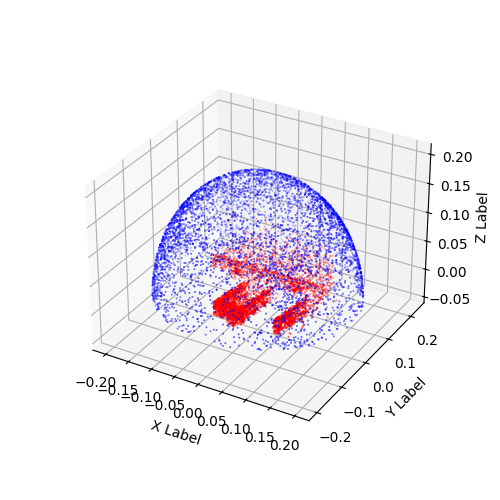

In [382]:

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')


# Plot the scatter points
arr_shape = gaussians_shape_xyz / 5.
ax.scatter(arr_shape[:,0], 
           arr_shape[:,1], 
           arr_shape[:,2], c='b', marker='o',s=0.1)

# Plot the scatter points
arr = target_points_torch.detach().cpu().numpy()

arr = np.array(arr)
ax.scatter(arr[:,0], 
           arr[:,1], 
           arr[:,2], c='r', marker='o',s=0.1)

# arr_rot = vecs_torch.detach().cpu().numpy() / 10.
# for i in range(len(indices)): 
#     idx = indices[i]
#     ax.plot([arr[idx,0], arr[idx,0] + arr_rot[idx,0]],
#             [arr[idx,1], arr[idx,1] + arr_rot[idx,1]],
#             [arr[idx,2], arr[idx,2] + arr_rot[idx,2]],
#            color=colors[i])
            

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

Text(0.5, 0, 'Z Label')

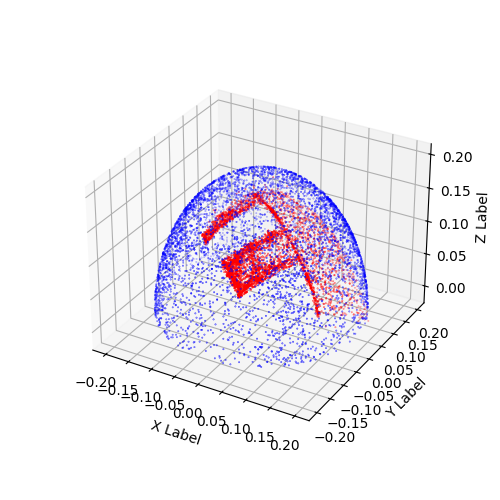

In [383]:

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')


# Plot the scatter points
arr_shape = gaussians_shape_xyz / 5.
ax.scatter(arr_shape[:,0], 
           arr_shape[:,1], 
           arr_shape[:,2], c='b', marker='o',s=0.1)

# Plot the scatter points
arr = points_torch.detach().cpu().numpy()

arr = np.array(arr)
ax.scatter(arr[:,0], 
           arr[:,1], 
           arr[:,2], c='r', marker='o',s=0.1)

# arr_rot = vecs_torch.detach().cpu().numpy() / 10.
# for i in range(len(indices)): 
#     idx = indices[i]
#     ax.plot([arr[idx,0], arr[idx,0] + arr_rot[idx,0]],
#             [arr[idx,1], arr[idx,1] + arr_rot[idx,1]],
#             [arr[idx,2], arr[idx,2] + arr_rot[idx,2]],
#            color=colors[i])
            

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

Text(0.5, 0, 'Z Label')

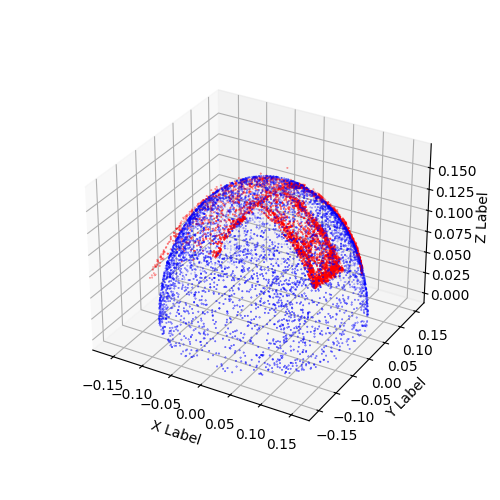

In [386]:

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')


# Plot the scatter points
arr_shape = domain_points_torch.detach().cpu().numpy()
#arr_shape = gaussians_shape_xyz / 5.
ax.scatter(arr_shape[:,0], 
           arr_shape[:,1], 
           arr_shape[:,2], c='b', marker='o',s=0.1)

# Plot the scatter points
arr = points_torch.detach().cpu().numpy()

arr = np.array(arr)
ax.scatter(arr[:,0], 
           arr[:,1], 
           arr[:,2], c='r', marker='o',s=0.1)

# arr_rot = vecs_torch.detach().cpu().numpy() / 10.
# for i in range(len(indices)): 
#     idx = indices[i]
#     ax.plot([arr[idx,0], arr[idx,0] + arr_rot[idx,0]],
#             [arr[idx,1], arr[idx,1] + arr_rot[idx,1]],
#             [arr[idx,2], arr[idx,2] + arr_rot[idx,2]],
#            color=colors[i])
            

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

Text(0.5, 0, 'Z Label')

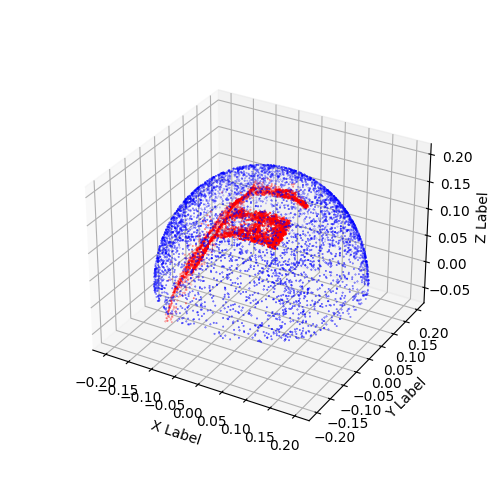

In [377]:

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')


# Plot the scatter points
arr_shape = gaussians_shape_xyz / 5.
ax.scatter(arr_shape[:,0], 
           arr_shape[:,1], 
           arr_shape[:,2], c='b', marker='o',s=0.1)

# Plot the scatter points
arr = points_torch.detach().cpu().numpy()

arr = np.array(arr)
ax.scatter(arr[:,0], 
           arr[:,1], 
           arr[:,2], c='r', marker='o',s=0.1)

# arr_rot = vecs_torch.detach().cpu().numpy() / 10.
# for i in range(len(indices)): 
#     idx = indices[i]
#     ax.plot([arr[idx,0], arr[idx,0] + arr_rot[idx,0]],
#             [arr[idx,1], arr[idx,1] + arr_rot[idx,1]],
#             [arr[idx,2], arr[idx,2] + arr_rot[idx,2]],
#            color=colors[i])
            

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

Text(0.5, 0, 'Z Label')

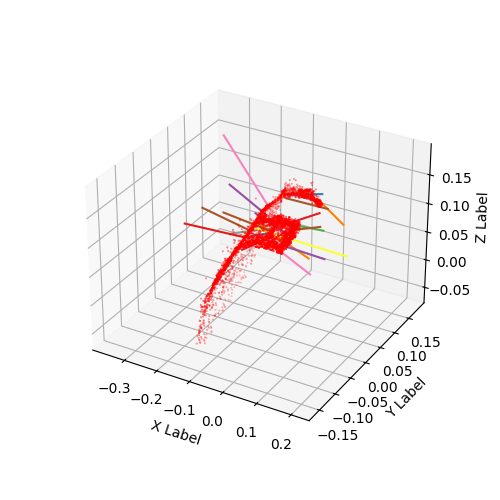

In [370]:

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')


# Plot the scatter points
# arr_shape = gaussians_shape_xyz / 5.
# ax.scatter(arr_shape[:,0], 
#            arr_shape[:,1], 
#            arr_shape[:,2], c='b', marker='o',s=0.1)

# Plot the scatter points
arr = points_torch.detach().cpu().numpy()

arr = np.array(arr)
ax.scatter(arr[:,0], 
           arr[:,1], 
           arr[:,2], c='r', marker='o',s=0.1)

arr_rot = vecs_torch.detach().cpu().numpy() / 10.
for i in range(len(indices)): 
    idx = indices[i]
    ax.plot([arr[idx,0], arr[idx,0] + arr_rot[idx,0]],
            [arr[idx,1], arr[idx,1] + arr_rot[idx,1]],
            [arr[idx,2], arr[idx,2] + arr_rot[idx,2]],
           color=colors[i])
            

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

Text(0.5, 0, 'Z Label')

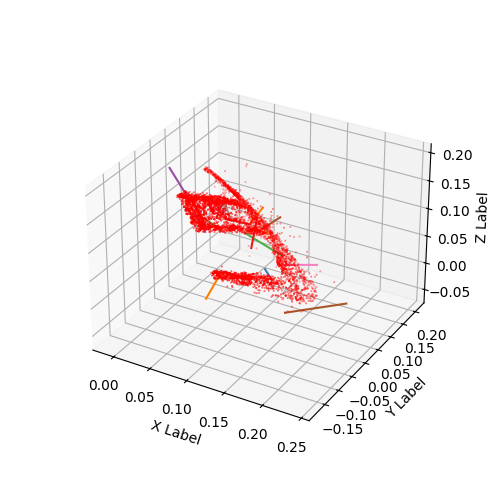

In [302]:

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')


# Plot the scatter points
# arr_shape = gaussians_shape_xyz / 5.
# ax.scatter(arr_shape[:,0], 
#            arr_shape[:,1], 
#            arr_shape[:,2], c='b', marker='o',s=0.1)

# Plot the scatter points
arr = points_torch.detach().cpu().numpy()

arr = np.array(arr)
ax.scatter(arr[:,0], 
           arr[:,1], 
           arr[:,2], c='r', marker='o',s=0.1)

arr_rot = vecs_torch.detach().cpu().numpy()
for i in range(len(indices)): 
    idx = indices[i]
    ax.plot([arr[idx,0], arr[idx,0] + arr_rot[idx,0]],
            [arr[idx,1], arr[idx,1] + arr_rot[idx,1]],
            [arr[idx,2], arr[idx,2] + arr_rot[idx,2]],
           color=colors[i])
            

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

Text(0.5, 0, 'Z Label')

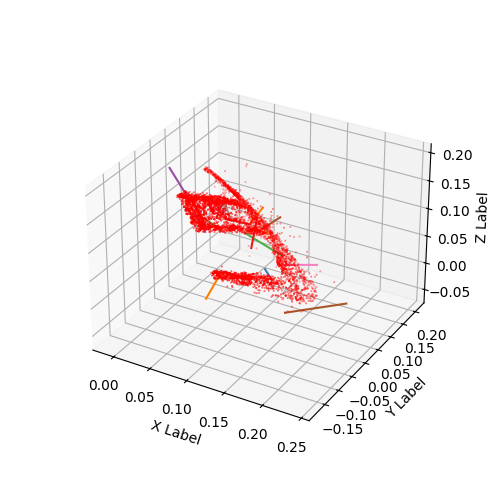

In [333]:

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')


# Plot the scatter points
# arr_shape = gaussians_shape_xyz / 5.
# ax.scatter(arr_shape[:,0], 
#            arr_shape[:,1], 
#            arr_shape[:,2], c='b', marker='o',s=0.1)

# Plot the scatter points
arr = points_torch.detach().cpu().numpy()

arr = np.array(arr)
ax.scatter(arr[:,0], 
           arr[:,1], 
           arr[:,2], c='r', marker='o',s=0.1)

arr_rot = vecs_torch.detach().cpu().numpy()
for i in range(len(indices)): 
    idx = indices[i]
    ax.plot([arr[idx,0], arr[idx,0] + arr_rot[idx,0]],
            [arr[idx,1], arr[idx,1] + arr_rot[idx,1]],
            [arr[idx,2], arr[idx,2] + arr_rot[idx,2]],
           color=colors[i])
            

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

## Now save scene with fitted coordinates and rotation vectors

In [371]:
import sys
sys.path.append("../")

from scene import GaussianModel
MODEL_DIR = './GT_lego_cluster2/'
#os.makedirs(MODEL_DIR, exist_ok = True)
gaussians_to_save = GaussianModel(sh_degree=3)
#gaussians_to_save.restore(torch.load("/home/dimakot55/output_data/gs_my/gs/GT_lego_cluster2/chkpnt1.pth")[0], opt)
gaussians_to_save.optimizer = torch.optim.Adam([gaussians_to_save._xyz], lr=1e-1)

In [372]:
# Store optimized parameters to the gaussias_to_save
gaussians_to_save._xyz = torch.tensor(points_torch.clone().detach())
gaussians_to_save._rotation = torch.tensor(vecs_torch.clone().detach())
#gaussians_to_save._rotation = torch.tensor(loaded_data['gaussians_target_rotation'])

gaussians_to_save._features_dc = torch.tensor(loaded_data['gaussians_target_features_dc'])
gaussians_to_save._features_rest = torch.tensor(loaded_data['gaussians_target_features_rest'])
gaussians_to_save._scaling = torch.tensor(loaded_data['gaussians_target_scaling'])

gaussians_to_save._opacity = torch.tensor(loaded_data['gaussians_target_opacity'])



/tmp/ipykernel_1056398/2875136665.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_to_save._xyz = torch.tensor(points_torch.clone().detach())
/tmp/ipykernel_1056398/2875136665.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_to_save._rotation = torch.tensor(vecs_torch.clone().detach())


In [373]:
iteration=1
torch.save((gaussians_to_save.capture(), iteration), MODEL_DIR + "/chkpnt" + str(iteration) + ".pth")
gaussians_to_save.save_ply(os.path.join(MODEL_DIR, "point_cloud/iteration_1/", "point_cloud.ply"))

Text(0.5, 0, 'Z Label')

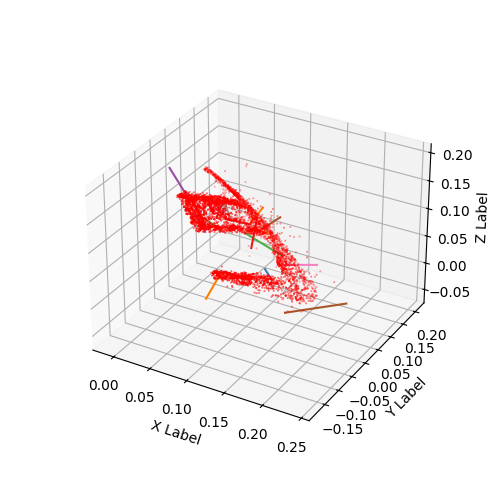

In [294]:

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')


# Plot the scatter points
# arr_shape = gaussians_shape_xyz / 5.
# ax.scatter(arr_shape[:,0], 
#            arr_shape[:,1], 
#            arr_shape[:,2], c='b', marker='o',s=0.1)

# Plot the scatter points
arr = points_torch.detach().cpu().numpy()

arr = np.array(arr)
ax.scatter(arr[:,0], 
           arr[:,1], 
           arr[:,2], c='r', marker='o',s=0.1)

arr_rot = vecs_torch.detach().cpu().numpy()
for i in range(len(indices)): 
    idx = indices[i]
    ax.plot([arr[idx,0], arr[idx,0] + arr_rot[idx,0]],
            [arr[idx,1], arr[idx,1] + arr_rot[idx,1]],
            [arr[idx,2], arr[idx,2] + arr_rot[idx,2]],
           color=colors[i])
            

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

Text(0.5, 0, 'Z Label')

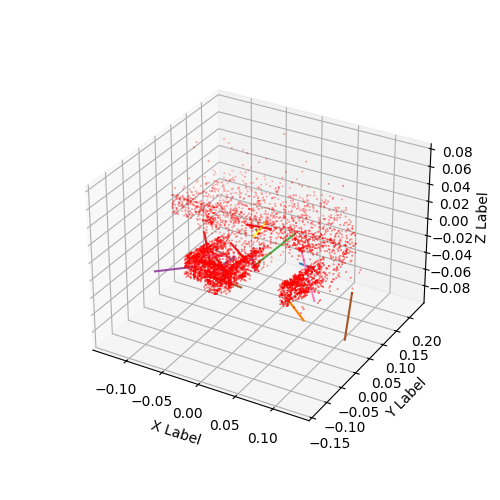

In [296]:

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')


# Plot the scatter points
# arr_shape = gaussians_shape_xyz / 5.
# ax.scatter(arr_shape[:,0], 
#            arr_shape[:,1], 
#            arr_shape[:,2], c='b', marker='o',s=0.1)

# Plot the scatter points
arr = target_points_torch.detach().cpu().numpy()

arr = np.array(arr)
ax.scatter(arr[:,0], 
           arr[:,1], 
           arr[:,2], c='r', marker='o',s=0.1)

arr_rot = target_vecs_torch.detach().cpu().numpy()
for i in range(len(indices)): 
    idx = indices[i]
    ax.plot([arr[idx,0], arr[idx,0] + arr_rot[idx,0]],
            [arr[idx,1], arr[idx,1] + arr_rot[idx,1]],
            [arr[idx,2], arr[idx,2] + arr_rot[idx,2]],
           color=colors[i])
            

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

Text(0.5, 0, 'Z Label')

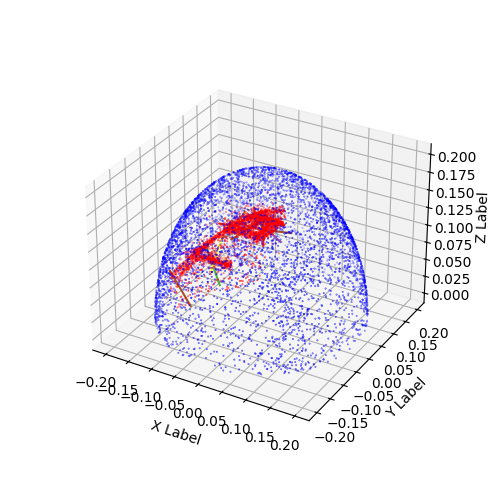

In [285]:

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')


# Plot the scatter points
arr_shape = gaussians_shape_xyz / 5.
ax.scatter(arr_shape[:,0], 
           arr_shape[:,1], 
           arr_shape[:,2], c='b', marker='o',s=0.1)

# Plot the scatter points
arr = points_torch.detach().cpu().numpy()

arr = np.array(arr)
ax.scatter(arr[:,0], 
           arr[:,1], 
           arr[:,2], c='r', marker='o',s=0.1)

arr_rot = vecs_torch.detach().cpu().numpy()
for i in range(len(indices)): 
    idx = indices[i]
    ax.plot([arr[idx,0], arr[idx,0] + arr_rot[idx,0]],
            [arr[idx,1], arr[idx,1] + arr_rot[idx,1]],
            [arr[idx,2], arr[idx,2] + arr_rot[idx,2]],
           color=colors[i])
            

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

Text(0.5, 0, 'Z Label')

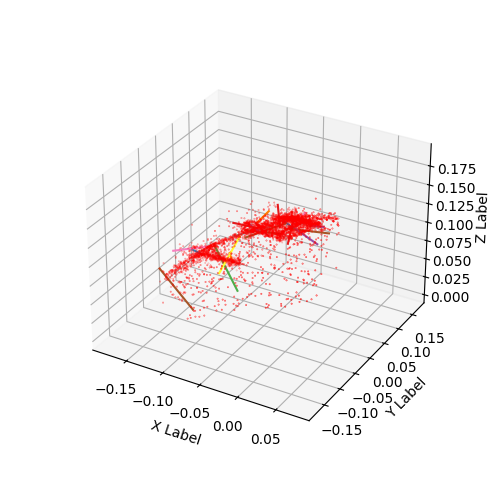

In [286]:

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')


# Plot the scatter points
# arr_shape = gaussians_shape_xyz / 5.
# ax.scatter(arr_shape[:,0], 
#            arr_shape[:,1], 
#            arr_shape[:,2], c='b', marker='o',s=0.1)

# Plot the scatter points
arr = points_torch.detach().cpu().numpy()

arr = np.array(arr)
ax.scatter(arr[:,0], 
           arr[:,1], 
           arr[:,2], c='r', marker='o',s=0.1)

arr_rot = vecs_torch.detach().cpu().numpy()
for i in range(len(indices)): 
    idx = indices[i]
    ax.plot([arr[idx,0], arr[idx,0] + arr_rot[idx,0]],
            [arr[idx,1], arr[idx,1] + arr_rot[idx,1]],
            [arr[idx,2], arr[idx,2] + arr_rot[idx,2]],
           color=colors[i])
            

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

Text(0.5, 0, 'Z Label')

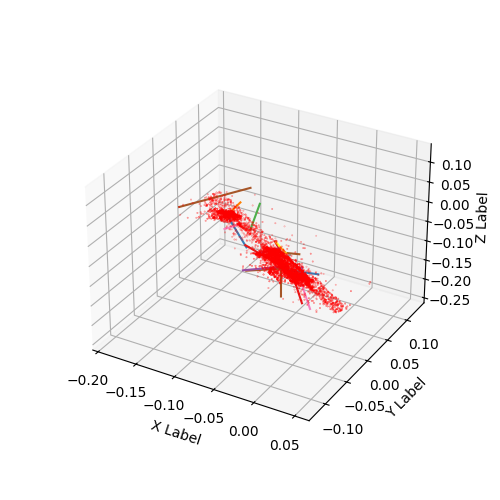

In [215]:

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')


# Plot the scatter points
# arr_shape = gaussians_shape_xyz / 5.
# ax.scatter(arr_shape[:,0], 
#            arr_shape[:,1], 
#            arr_shape[:,2], c='b', marker='o',s=0.1)

# Plot the scatter points
arr = points_torch.detach().cpu().numpy()

arr = np.array(arr)
ax.scatter(arr[:,0], 
           arr[:,1], 
           arr[:,2], c='r', marker='o',s=0.1)

arr_rot = vecs_torch.detach().cpu().numpy()
for i in range(len(indices)): 
    idx = indices[i]
    ax.plot([arr[idx,0], arr[idx,0] + arr_rot[idx,0]],
            [arr[idx,1], arr[idx,1] + arr_rot[idx,1]],
            [arr[idx,2], arr[idx,2] + arr_rot[idx,2]],
           color=colors[i])
            

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')